<a href="https://colab.research.google.com/github/MTracchia/Laboratorio-de-Datos/blob/main/Clases/Datos%20georeferenciados/Clase_Datos_Georef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a datos georeferenciados

En estas líneas, veremos brevemente cómo trabajar con geometrías tipo puntos, líneas y polígonos, y en particular, abordaremos con estas herramientas el problema de los datos georeferenciados

In [ ]:
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 

# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
!pip install pyproj

import shapely as shp # Geometrías básicas
import geopandas as gpd # Data frames geo referenciados
import pyproj # Geometrías en 3D
import ee # Google Earth Engine
import folium # Mapas interactivos!

import matplotlib.pylab as plt # Viejo y confiable
from matplotlib.colors import ListedColormap # Maldito geopandas y sus bugs

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

## Trabajando con figuras en 2D

[Shapely](https://shapely.readthedocs.io/en/stable/manual.html) es una amigable librería para manejar figuras geométricas. Está bueno familiarizarse con los distintos recursos que tiene, porque después será una de las bases del trabajo georeferenciado. Nuestras ciudades serán puntos, los recorridos de colectivos líneas y las áreas de alerta sanitaria serán polígonos.

Las figuras geométricas las vamos a crear a partir del módulo:


```
# puntos 
shapely.geometry.Point()
# líneas
shapely.geometry.Line()
# polígonos
shapely.geometry.Polygon()
```



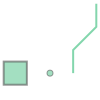

In [ ]:
punto = shp.geometry.Point([0,0]) # un punto
linea = shp.geometry.LineString([[1,0],[1,1],[2,2],[2,3]]) # una línea
poligono = shp.geometry.Polygon([[-1,0.5], [-1,-0.5],[-2,-0.5], [-2,0.5]]) # un polígono

shp.geometry.GeometryCollection([punto, linea, poligono]) # Generamos esta colección de geometrías para poder visualizarlas rápidamente todas juntas

Ahora, lo que podemos llegar a preguntarnos es:


*   ¿Cuál es la distancia entre nuestro punto al resto de las figuras?
*   ¿Cuál es el largo de la línea?
*   ¿Cuáles son el área y perímetro de nuestro polígono?

shapely nuevamente nos ayuda con esto. Básicamente, los objetos que recién creamos tienen ciertos atributos como:

```
 .distance(other)
 .area()
 .centroid()

```



In [ ]:
# Algunas medidas sobre las figuras:
print(f'La distancia del punto a la línea es {punto.distance(linea)}')
print(f'La distancia del punto al poligono es {punto.distance(poligono)}')
print(f'El largo de la línea es {linea.length}')
print(f'El perímetro del polígono es {poligono.length} y su área es {poligono.area}')


La distancia del punto a la línea es 1.0
La distancia del punto al poligono es 1.0
El largo de la línea es 3.414213562373095
El perímetro del polígono es 4.0 y su área es 1.0


No sé a ustedes, pero a mí me quedan preguntas sobre cómo se calculan las distancias entre figuras (y van a surgir más adelante dudas sobre cómo se calculan las áreas)

Entonces, tratemos de ver qué está pasando

In [ ]:
# Creemos una línea entre algún punto del polígono y el punto y preguntémosle la distancia

print(f'La distancia entre el punto y alguna coordenada del polígono es: {shp.geometry.LineString([punto, poligono.exterior.coords[0]]).length}')

# Al recorrer los distintos puntos, no encontramos lo que queremos... Probemos con el centro de masa del polígono

print(f'La distancia entre el punto y el centroide del polígono es: {shp.geometry.LineString([punto, poligono.centroid]).length}')

# Tampoco funciona, tratemos de entender qué está pasando, usando otro módulo de shapely -ops-

puntos_cercanos = shp.ops.nearest_points(punto, poligono) # Encuentra los puntos más cercanos entre dos geometrías, nos devuelve ambos puntos (en este caso, uno va a ser el mismo punto original)

print(f'La distancia entre el punto y el polígono entonces es: {puntos_cercanos[0].distance(puntos_cercanos[1])}')
print('Entonces, la distancia se calcula entre los puntos más cercanos de ambas figuras')

La distancia entre el punto y alguna coordenada del polígono es: 1.118033988749895
La distancia entre el punto y el centroide del polígono es: 1.5
La distancia entre el punto y el polígono entonces es: 1.0
Entonces, la distancia se calcula entre los puntos más cercanos de ambas figuras


Shapely nos ofrece varios métodos más que está bueno conocerlos:



*   Evaluar intersecciones entre figuras
*   Evaluar cómo están construidas estas figuras (que tiene un efecto en cómo se calcula el área en ciertos paquetes)
*   Generar anillos de puntos que se encuentren a cierta de distancia de nuestras figuras
*   etc.

Sugerencia para visualizar estas cosas: usar geopandas, muy parecida a pandas, pero con una nueva columna -geometry.



## Geopandas y los data frames con geometrías

Como su nombre lo indica, [geopandas](https://geopandas.org/) es una librería que integra geometría con pandas: ¿qué má queré?

Si bien tiene algunos bugs, es una gran herramienta para trabajar con datos georeferenciadas. Sin ir más lejos, nos permite manejar geometrías y visualizarlas mucho más fácil que sólo trabajando con shapely.

Después veremos cómo la usamos con bases de datos de verdad.

Así como antes el `pd.DataFrame` era el objeto fundamental de pandas, acá el `gpd.GeoDataFrame` va a ser el objeto fundamental



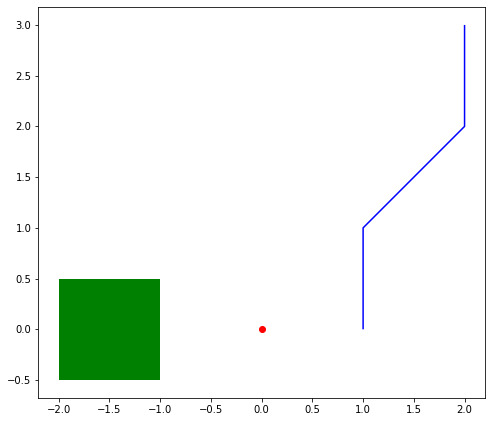

In [ ]:
d = gpd.GeoDataFrame(data = {'geometry' : [punto, linea, poligono],
                             'color' : ['red', 'blue', 'green']},
                     ) # Vemos entonces que es muy similar a pandas la forma de construir el geoDataFrame

fig, ax = plt.subplots(figsize = (8,8))
ax.set_aspect('equal')
d.plot(ax = ax,
       cmap = ListedColormap(d.color), # Tardé mucho en descubrir esto
       )

plt.show()

## Geopandas y ahora sí datos georeferenciados

Veamos entonces ahora sí cómo explotar al funcionalidad de geopandas para trabajar con datos geo referenciados.

Ejemplos sobran, pero en este caso trabajaremos con tres bases de datos del Gobierno de la Ciudad Autónoma de Buenos Aires:


*   Los polígonos de las manzanas
*   Los polígonos de espacios verdes
*   Los espacios de salud públicos: Hospitales y CESACS

El objetivo de trabajar con estos datos es darle a cada manzana de la ciudad una distancia a espacios verdes por un lado y cetros de salud por el otro.

Queremos visualizar estas distancias para ver si a ojo podemos ver diferencias entre qué tan cerca están las manzanas de determinados espacios.

Este tipo de trabajos suele hacerse para evaluar la calidad de vida en términos del acceso a ciertos servicios/derechos/el nombre que corresponda.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_manzanas = '/content/drive/My Drive/Clase_Datos_Georef/manzanas'
file_espaciosVerdes = '/content/drive/My Drive/Clase_Datos_Georef/espaciosVerdes'
file_saludHospitales = '/content/drive/My Drive/Clase_Datos_Georef/hospitales/hospitales_gcba'
file_saludCesac = '/content/drive/My Drive/Clase_Datos_Georef/cesac/centros de salud'

d_manzanas = gpd.read_file(file_manzanas)
d_espaciosVerdes = gpd.read_file(file_espaciosVerdes)
d_saludHospitales = gpd.read_file(file_saludHospitales)
d_saludCesac = gpd.read_file(file_saludCesac)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Antes de ponernos a trabajar, está bueno ver qué onda cada uno de estos dataframes. Al margen de la distinta información que nos dan sobre cada punto/polígono, es muy importante chequear cuál es la proyección con la cual python está interpretando los datos georeferenciados.

Esto lo chequeamos con el método `gpd.GeoDataFrame().crs` que hace referencia al Sistema de Referencia de Coordenadas (Coordinate Reference System).

In [ ]:
print("\033[1m" + "El crs de las manzanas" + "\033[0m")
print(d_manzanas.crs)
print("\033[1m" + "El crs de los espacios verdes" + "\033[0m")
print(d_espaciosVerdes.crs)
print("\033[1m" + "El crs de los hospitales" + "\033[0m")
print(d_saludHospitales.crs)
print("\033[1m" + "El crs de los CESACs" + "\033[0m")
print(d_saludCesac.crs)

El crs de las manzanas
epsg:4326
El crs de los espacios verdes
epsg:4326
El crs de los hospitales
PROJCS["Argentina_GKBsAs",GEOGCS["Campo Inchauspe",DATUM["Campo_Inchauspe",SPHEROID["International 1924",6378388,297,AUTHORITY["EPSG","7022"]],AUTHORITY["EPSG","6221"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4221"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",-34.6297166],PARAMETER["central_meridian",-58.4627],PARAMETER["scale_factor",0.999998],PARAMETER["false_easting",100000],PARAMETER["false_northing",100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
El crs de los CESACs
epsg:4326


Vemos que el data frame de los hospitales es distinto al del resto. Además, el epsg : 4326 nos va a permitir entender a los datos como puntos/polígonos dentro de una geometría no euclideana (con el perdón de tierraplanistas). Entonces, vamos a llevar a data frame de hospitales a la proyección del resto. Esto es bastante simple, usando el método `gpd.GeoDataFrame().to_csr(algun_crs)`

In [ ]:
d_saludHospitales.to_crs(d_saludCesac.crs, inplace = True)
print("\033[1m" + "El crs de los hospitales ahora es" + "\033[0m")
print(d_saludHospitales.crs)

El crs de los hospitales ahora es
epsg:4326


Como no vamos a hacer un análisis separado entre cesac y hospitales, tratemos de extender ambos data frames para llevarlo a uno solo

In [ ]:
d_salud = d_saludCesac.append(d_saludHospitales)
# Las keys quedan medio en cualquiera, pero lo importante es que la geometry está toda en la misma columna

del d_saludCesac, d_saludHospitales # Deleteo los data frames, son chiquitos, pero bueno, está bien ahorrarle recursos a los servidores de google...dijo nadie nunca

Como tal vez no nos aguantamos la manija, vamos a ver cómo se ven estos datos al graficarlos

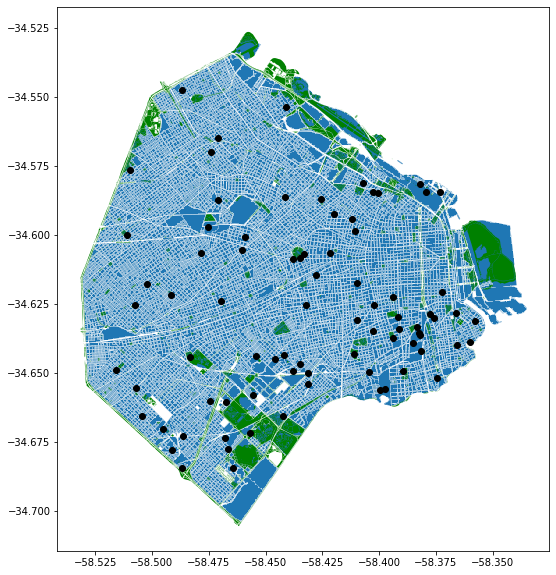

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect('equal')
d_manzanas.plot(ax = ax,)
d_espaciosVerdes.plot(ax = ax, color = 'green')
d_salud.plot(ax = ax, color = 'black')

plt.show()


Lo que sigue entonces es tratar de implementar el cálculo de distancias de cada manzana a los espacios verdes y centros de salud.

Debe haber varias formas de hacer esto, pero acá el camino que tomaremos es el siguiente: en vez de calcular la distancia de cada manzana a cada hospital, vamos a generarnos una colección de puntos (en el caso de los espacios verdes será una colección de polígonos), de forma tal de performar un único cálculo de distancia de una manzana a los centros de salud, y sabemos por lo que vimos antes que va a ser la menor distancia.

Ahora bien, fijémonos una cosita antes...

In [ ]:
# Le pedimos el área a los polígonos...
d_manzanas[:20].geometry.apply(lambda x: x.area)
# Nos devuelve esto...qué está pasando? Por lo que pude leer, hay problemitas con geopandas calculando cosas en geometrías no euclideanas. Entonces, hagamos uso de pyproj

0     1.126470e-09
1     3.767130e-13
2     1.881610e-09
3     6.711964e-09
4     1.024579e-08
5     8.516346e-09
6     9.198712e-11
7     3.256139e-09
8     7.921324e-09
9     4.497656e-09
10    1.510446e-08
11    2.288801e-08
12    2.752964e-08
13    3.219499e-08
14    3.683669e-08
15    3.231860e-08
16    2.954810e-09
17    4.820117e-09
18    4.735458e-14
19    3.195375e-08
Name: geometry, dtype: float64

Acá la documentación de [pyproj](https://pyproj4.github.io/pyproj/stable/) para que consulten

In [ ]:
# La idea de pyproj es que nos permite laburar con geometrías elipsoideales como las utilizadas con el crs que estamos trabajando
geod = pyproj.Geod(ellps = 'WGS84') # Inicializamos un objeto pyproj.Geod() en el cual le indicamos el crs con el que queremos trabajar
d_manzanas[:20].geometry.apply(lambda x: geod.geometry_area_perimeter(x))
# Ahora vemos algo más razonable, salvo por el hecho de que ahora tenemos áreas y perímetros... Ah re, no eso no es lo sorprendente, sino que las áreas son negativas
# Pensando en cómo se calculan estas áreas, parece que es importante cómo están definidos los puntos de los polígonos (si están definidos horaria o antihorariamente...)
# Si bien no estamos queriendo calcular áreas, estaría bueno que esto no ocurra, o sí, qué sé yo. Al margen, se pueden dar vuelta los polígonos

0        (-11.460634595481679, 44.353819958941436)
1     (-0.0038454603109130403, 0.3020839184833881)
2        (-19.143438558094203, 21.647769227558168)
3          (-68.28743335884064, 49.37786631951121)
4         (-104.24100574757904, 50.40257465528016)
5          (-86.64568806090392, 51.26362276647703)
6           (-0.9358070120215416, 12.747798526466)
7         (-33.125525041949004, 64.83367843561558)
8          (-80.58585553150624, 67.86245691708885)
9         (-45.75598542159423, 34.259650051615075)
10        (-153.66289769671857, 65.11067841542837)
11         (-232.8483709571883, 77.57851990282651)
12         (-280.0704054515809, 80.59200901118751)
13        (-327.53400166798383, 83.62089221071876)
14         (-374.7573146931827, 86.63442221620511)
15         (-328.79360221416573, 81.6561524242347)
16       (-30.060952588682994, 26.262956959599393)
17          (-49.03765317797661, 33.8235402756938)
18    (-0.00046915485836507287, 0.107090777156017)
19         (-325.0838692057878,

In [ ]:
def reorienta(x): # Con esta funcioncita, podemos reorientar los polígonos cosa de que las áreas sean positivas
    if x.geom_type == 'Polygon':
        return shp.geometry.polygon.orient(x,
                                           sign = 1)
    elif x.geom_type == 'MultiPolygon': # Para el caso de los multipolígonos, tenemos que ser cuidadoses y recorrer cada polígono que esté adentro
        pols = []
        for pol in x:
            pols.append(shp.geometry.polygon.orient(pol,
                                                    sign = 1)
                        )
        return shp.geometry.MultiPolygon(pols)



In [ ]:
d_manzanas[:20].geometry.apply(lambda x: geod.geometry_area_perimeter(reorienta(x))[0])
# Y ahora, el área está positiva y podemos dormir tranquiles

0      11.460635
1       0.003845
2      19.143439
3      68.287433
4     104.241006
5      86.645688
6       0.935807
7      33.125525
8      80.585856
9      45.755985
10    153.662898
11    232.848371
12    280.070405
13    327.534002
14    374.757315
15    328.793602
16     30.060953
17     49.037653
18      0.000469
19    325.083869
Name: geometry, dtype: float64

In [ ]:
# Bueno, a lo que íbamos:
centros_salud = shp.geometry.GeometryCollection(d_salud.geometry.to_list()) # Generamos un único objeto de centros de salud
areas_verdes = shp.geometry.GeometryCollection(d_espaciosVerdes[(d_espaciosVerdes.nombre.str.contains('Gral. Paz') != True) & (d_espaciosVerdes['area'] > 10000)].geometry.to_list()) # Generamos un único objeto de áreas verdes

In [ ]:
"""
Teniendo en cuenta cómo funciona el cálculo de distancias para pyproj, tenemos que hacer una pequeña jugarreta.

Básicamente, vamos a usar el objeto geod que definimos arriba, y usar el método geod.inv().

Ahora bien, para esto, necesitamos pasarle cuatro argumentos a la función

- lat_inicial
- long_inicial
- lat_final
- long_inicial

y nos va a devolver la distancia en grados (en ambas direccione) y la distancia en metros

Teniendo en cuenta que vamos a trabaja con colecciones de puntos y polígonos, para definir los puntos a utilizar vamos a trabajar con
los puntos más cercanos entre la manzana y los puntos o polígonos con los qu estemos trabajados (podríamos optar por el centroide de las manzanas, pero bue,
en la vida hay que elegir se supo decir)
"""

def distancia_manzanas_servicios(manzana, servicio, geod = pyproj.Geod(ellps = 'WGS84')):
    punto_inicial, punto_final = shp.ops.nearest_points(manzana, servicio)

    lat_inicial = punto_inicial.y # El eje y es la latitud
    long_inicial = punto_inicial.x # El eje x es la longitud

    lat_final = punto_final.y
    long_final = punto_final.x

    un_angulo, otro_angulo, distancia =  geod.inv(lat_inicial,
                                                  long_inicial,
                                                  lat_final,
                                                  long_final)
    return distancia

In [ ]:
# Defino la columna distancia a espacios verdes

d_manzanas['dist_espacios_verdes'] = d_manzanas.geometry.apply(lambda x: distancia_manzanas_servicios(x,
                                                                                                      areas_verdes))

# Defino la columna distancia a centros de salud

d_manzanas['dist_salud'] = d_manzanas.geometry.apply(lambda x: distancia_manzanas_servicios(x,
                                                                                            centros_salud))

Podemos rápidamente ver la estadística de estas distancias

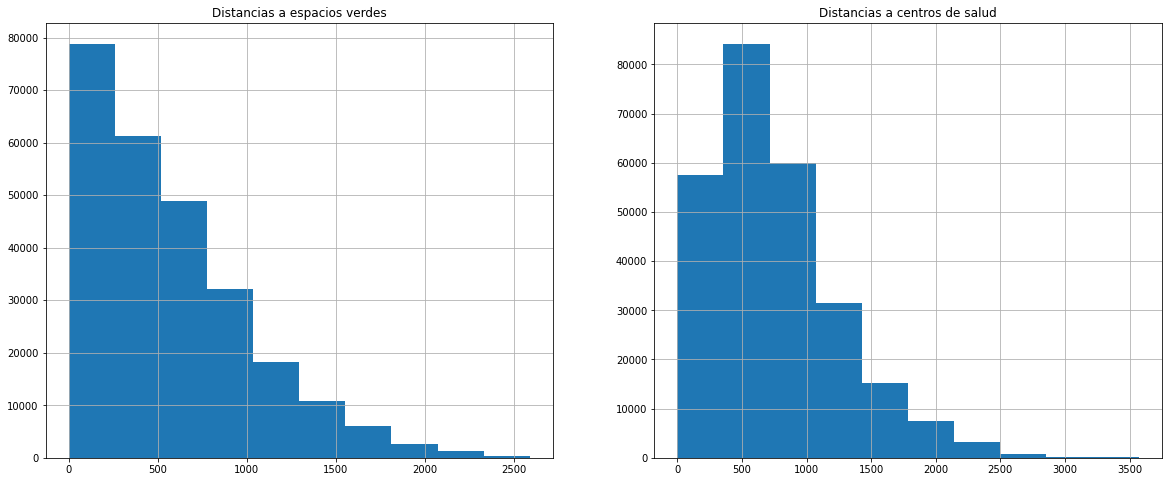

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (20,8))

axs[0].set_title('Distancias a espacios verdes')
d_manzanas.dist_espacios_verdes.hist(ax = axs[0])

axs[1].set_title('Distancias a centros de salud')
d_manzanas.dist_salud.hist(ax = axs[1])

plt.show()

Y ahora podemos visualizar cómo se mapean estas distancias en la geografía de la ciudad:

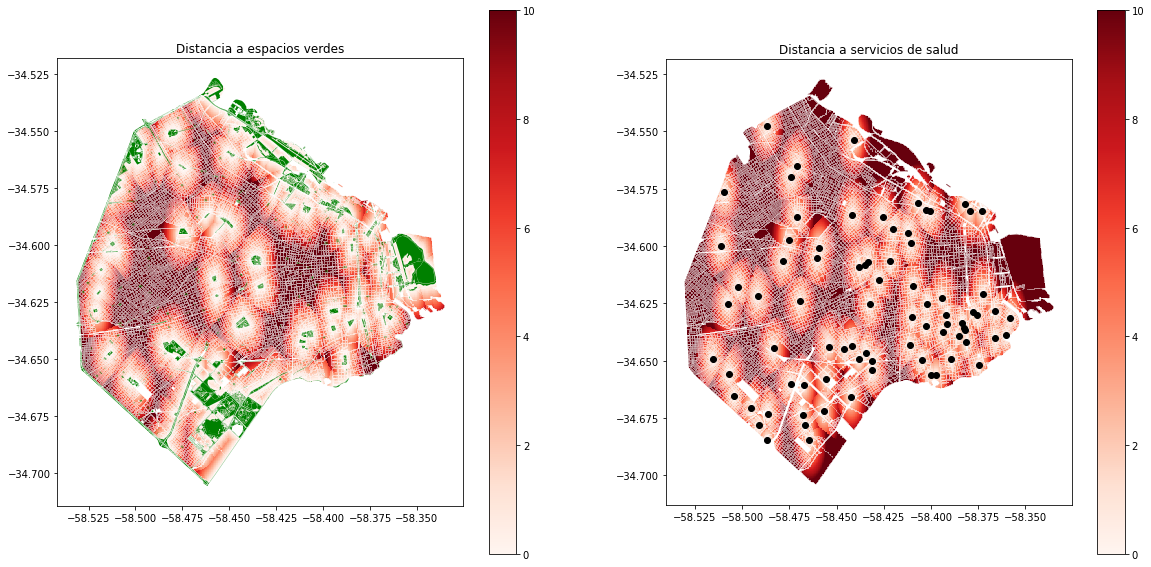

In [ ]:
d_manzanas['dist_espacios_verdes_norm'] = d_manzanas.dist_espacios_verdes / 100 # Queremos ver los resultados en términos de una distancia característica (una cuadra = 100m)
d_manzanas['dist_salud_norm'] = d_manzanas.dist_salud / 100


fig, axs = plt.subplots(1,2, figsize = (20,10))

d_manzanas.plot(column = 'dist_espacios_verdes_norm', # Este método permite indicarle a través de cuál columna nos colorea los polígonos
                legend = True, # Con esto, activamos de forma automática la barra de colores
                ax = axs[0],
                cmap = 'Reds',
                vmax = 10)
d_espaciosVerdes.plot(ax = axs[0], color = 'green')

d_manzanas.plot(column = 'dist_salud_norm',
                legend = True,
                ax = axs[1],
                cmap = 'Reds',
                vmax = 10)
d_salud.plot(ax = axs[1], color = 'black')
axs[0].set_title('Distancia a espacios verdes')
axs[1].set_title('Distancia a servicios de salud')
plt.show() 

## Agregando datos

Listo, tenemos lo que queríamos para cada manzana. Supongamos ahora que nos interesa tener una mirada más global sobre la situación, y estudiar el problema a escala barrial.

Lo que podemos hacer, es traer otra base de datos, la de barrios, y hacer un merge según la geometría. Esto nos va a permirtir que cada manzana quede asignada a un barrio, así, estudiaremos el valor medio de las distancias para las manzanas de cada barrio. Para esto, vamos a usar la función `gpd.sjoin()`

In [ ]:
file_barrios = '/content/drive/My Drive/Clase_Datos_Georef/barrios'

d_barrios = gpd.read_file(file_barrios)
if d_barrios.crs != d_manzanas.crs:
    d_barrios.to_crs(d_manzanas.crs,
                     inplace = True)
d_manzanas_barrio = gpd.sjoin(d_barrios,
                      d_manzanas,
                      how = 'left', # Preserva la geometría del dataframe de la derecha
                      op = 'covers' # Una forma de operar que devuelve True si el polígono izquierdo toca el borde o está dentro del polígono de la derecha https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates
                      )

In [ ]:
d_manzanas_barrio.keys()

Index(['BARRIO', 'COMUNA', 'PERIMETRO', 'AREA', 'OBJETO', 'geometry',
       'index_right', 'mvt_id', 'id', 'sm', 'tipo', 'dist_espacios_verdes',
       'dist_salud', 'dist_espacios_verdes_norm', 'dist_salud_norm'],
      dtype='object')

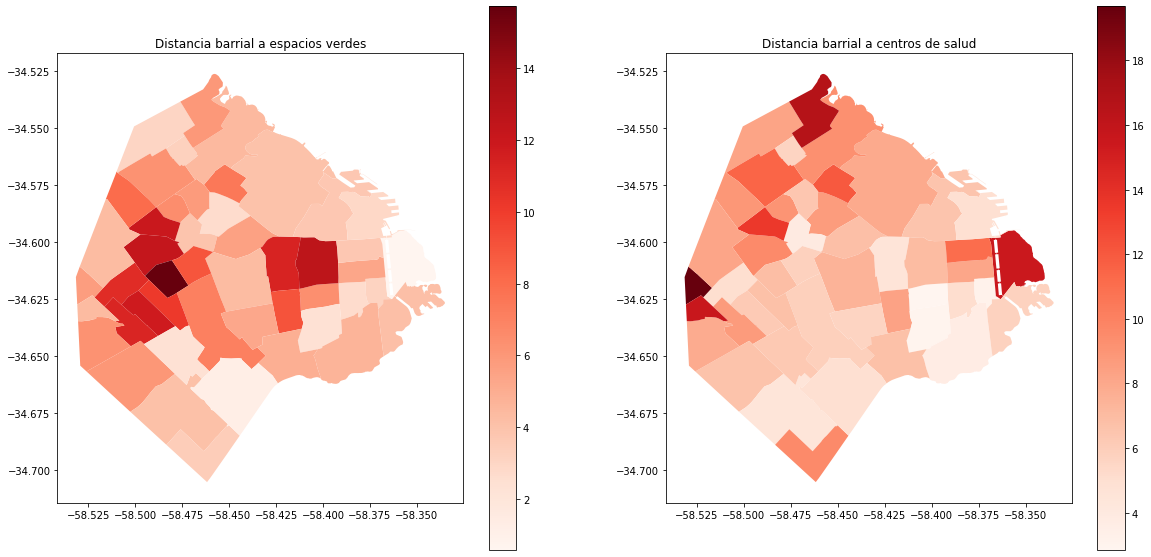

In [ ]:
d_barrios_dist_espaciosVerdes = d_manzanas_barrio[['dist_espacios_verdes_norm','BARRIO']].groupby('BARRIO').mean().reset_index()
d_barrios_dist_salud = d_manzanas_barrio[['dist_salud_norm','BARRIO']].groupby('BARRIO').mean().reset_index()

d_barrios_dist_espaciosVerdes = gpd.GeoDataFrame(d_barrios_dist_espaciosVerdes.merge(d_barrios[['BARRIO', 'geometry']],
                                                                    on = 'BARRIO',
                                                                    how = 'right'))

d_barrios_dist_salud = gpd.GeoDataFrame(d_barrios_dist_salud.merge(d_barrios[['BARRIO', 'geometry']],
                                                                    on = 'BARRIO',
                                                                    how = 'right'))
fig, axs = plt.subplots(1,2,figsize = (20,10))
axs[0].set_title('Distancia barrial a espacios verdes')
d_barrios_dist_espaciosVerdes.plot(ax = axs[0],
                                   column = 'dist_espacios_verdes_norm',
                                   legend = True,
                                   cmap = 'Reds')
axs[1].set_title('Distancia barrial a centros de salud')
d_barrios_dist_salud.plot(ax = axs[1],
                          column = 'dist_salud_norm',
                          legend = True,
                          cmap = 'Reds')
plt.show()

## El caso navegable

In [ ]:
m = folium.Map(location=[-34.6037,-58.3816], zoom_start=11)

c_1 = folium.Choropleth(
    geo_data=d_barrios_dist_espaciosVerdes,
    name="Distancia Espacios Verdes",
    data=d_barrios_dist_espaciosVerdes[["BARRIO", "dist_espacios_verdes_norm"]],
    columns=['BARRIO',"dist_espacios_verdes_norm"],
    key_on="feature.properties.BARRIO",
    fill_color="Reds",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Distancia Espacios Verdes (cuadras)",
    highlight = True
    ).add_to(m)
c_2 = folium.Choropleth(
    geo_data=d_barrios_dist_salud,
    name="Distancia Centros Salud",
    data=d_barrios_dist_salud[["BARRIO", "dist_salud_norm"]],
    columns=['BARRIO',"dist_salud_norm"],
    key_on="feature.properties.BARRIO",
    fill_color="Reds",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Distancia Centros de Salud (cuadras)",
    show = False,
    highlight = True
  ).add_to(m)

c_1.geojson.add_child(folium.features.GeoJsonTooltip(fields = ['BARRIO']))
c_2.geojson.add_child(folium.features.GeoJsonTooltip(fields = ['BARRIO']))

folium.LayerControl().add_to(m)

m


In [ ]:
m.save('mapita.html')

## Un poquito de Google Earth

Para dar un poco más de pochoclo a este colab, trabajemos con [Google Earth Engine](https://developers.google.com/earth-engine). La idea es que esta plataforma nos permite acceder a imágenes satelitales de distinto tipo y hay una trazabilidad temporal de dichas imágenes. Hay que aplicar de forma tal de que se nos autorice el acceso, pero no es difícil de hacerlo y sale. 

Acá sólo vamos a mostrar cómo traer una capa para poder armar un mapa navegable. [Acá](https://climada-python.readthedocs.io/en/stable/tutorial/climada_util_earth_engine.html) hay una introducción para trabajar de otras formas.

In [ ]:
ee.Authenticate() # Autenticamos la sesión
ee.Initialize() # La inicializamos

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=lMye_4tan9FTPwdwQXuAwSMJ2XVTNB76mQ3dTjkKOCE&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5Di17DijDIBscObdf24xebSXHaWuvjbdpk4FW9u6AIO8VWQbLfvJk

Successfully saved authorization token.


In [ ]:
# Esta función nos la sugiere GEE para sumarle una capa determinada a un mapa de follium
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer # Definimos cómo se suman capas de gee
 
first = (ee.ImageCollection('COPERNICUS/S2_SR') # Elegimos la imagen, pasamos ciertos parámetros
         .filterBounds(ee.Geometry.Point(-58.3816, -34.6037))
         .filterDate('2019-01-01', '2019-12-31')
         .sort('CLOUDY_PIXEL_PERCENTAGE')
         .first())

# Define a map centered on southern Maine.
map_s2 = folium.Map(location=[-34.6037, -58.3816], zoom_start=11)

# Add the image layer to the map and display it.
map_s2.add_ee_layer(
    first, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000}, 'first')
display(map_s2)